In [45]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import re
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import Counter
#from nltk.corpus import stopwords
import string
import operator
import seaborn as sns
%matplotlib inline

In [46]:
with open("../out/juicers.json", "r") as f:
    allJuicers = json.load(f)

priceListByBrand = {}
rankListByBrand = {}
juicersByAsin = {}
for cat, juicers in allJuicers.items():
    for juicer in juicers:
        asin = list(juicer.keys())[0]
        val = list(juicer.values())[0]
        val.update({"category":cat})
        if any(x in val['title'].lower() for x in ['juice','juicer']):
            juicersByAsin.update({asin: val})
        else:
            continue
        brand = val['brand']
        try:
            if brand.lower() == 'breville juicer':
                brand = 'breville'
        except:
            continue

        try:
            if brand.lower() == 'omega juicers':
                brand = 'omega'
        except:
            continue
        try:
            priceListByBrand.setdefault(brand, []).append(float(val['price'][1:]))
        except:
            pass

        try:
            if not val['sales_rank'] == 'None':
                rankListByBrand.setdefault(brand, []).append(int(val['sales_rank']))
        except:
            pass

df_all = pd.DataFrame(juicersByAsin)

df_all = df_all.T

In [47]:
df_all.head()

,brand,category,color,features,price,sales_rank,title
B00004R93U,Juiceman,centrifugal,Off-White,[Peppy 1/4-horsepower motor quickly juices mos...,$158.98,1006304,Juiceman Jr. Elite Pro JM211 Juice Extractor
B00004R93V,Juiceman,centrifugal,White,[Powerful 1/2-horsepower motor quickly juices ...,$79.95,778846,The Juiceman Electronic Professional Series 41...
B00004S8FH,Waring,centrifugal,White,[Converts all noncitrus fruits and vegetables ...,$360.00,227195,"Waring PJE401 Juice Extractor, Quite White and..."
B00004S8FI,Waring,citrus,Quite White,"[Juices all citrus fruits, from limes to grape...",None,254788,"Waring PCJ201 Citrus Juicer, Quite White"
B00004S8FJ,Waring,citrus,Stainless Steel,"[Juices all citrus fruits, from limes to grape...",$149.99,231125,"Waring PCJ218 Citrus Juicer, Stainless Steel"


#### Let's check the general characteristics

In [48]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1017 entries, B00004R93U to B0739LW3XS
Data columns (total 7 columns):
brand         1010 non-null object
category      1017 non-null object
color         839 non-null object
features      1017 non-null object
price         968 non-null object
sales_rank    1017 non-null object
title         1017 non-null object
dtypes: object(7)
memory usage: 63.6+ KB


In [49]:
df_all.isnull().sum()

brand           7
category        0
color         178
features        0
price          49
sales_rank      0
title           0
dtype: int64

In [50]:
(df_all=='None').sum()

brand           0
category        0
color           1
features        0
price           0
sales_rank    252
title           0
dtype: int64

In [51]:
df_all.dtypes

brand         object
category      object
color         object
features      object
price         object
sales_rank    object
title         object
dtype: object

In [52]:
df_all[df_all == 'None'] = float('NaN')

In [53]:
df_all.isnull().sum()

brand           7
category        0
color         179
features        0
price          49
sales_rank    252
title           0
dtype: int64

In [54]:
def getPrice(x):
    if x:
        x = x.replace(',','.')
        res = re.findall('\d+.\d+', x)
        if res:
            return float(res[0])
        else:
            return float('NaN')
    else:
        return x

In [55]:
df_all['price'] = df_all['price'].apply(getPrice)

In [59]:
# Normally, I would use int. However, as the pandas doesnt have the ability to store NaN values as int, I used float
# https://stackoverflow.com/a/21290084
df_all['sales_rank'] = df_all['sales_rank'].astype(float)

In [60]:
df_all.dtypes

brand          object
category       object
color          object
features       object
price         float64
sales_rank    float64
title          object
dtype: object

In [63]:
type(df_all['features'].iloc[0])

list

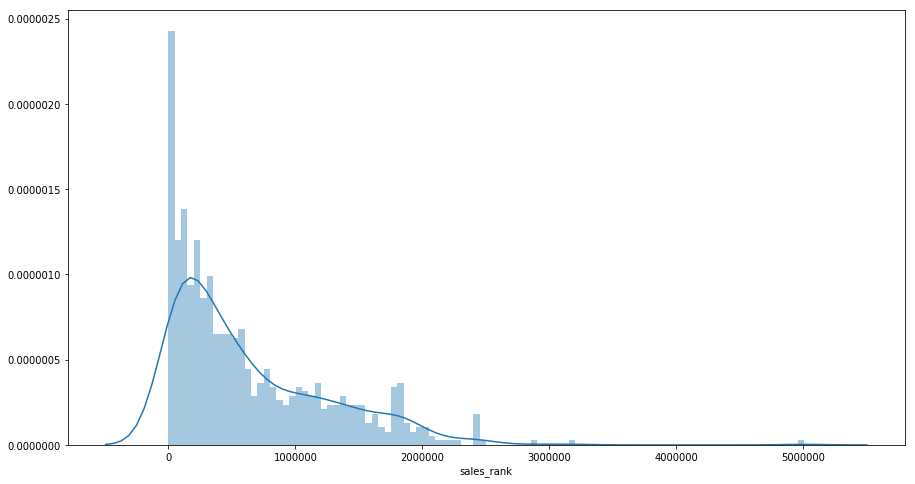

In [69]:
plt.figure(figsize=(15,8))
srank = df_all['sales_rank'].dropna()
sns.distplot(srank, bins=100)

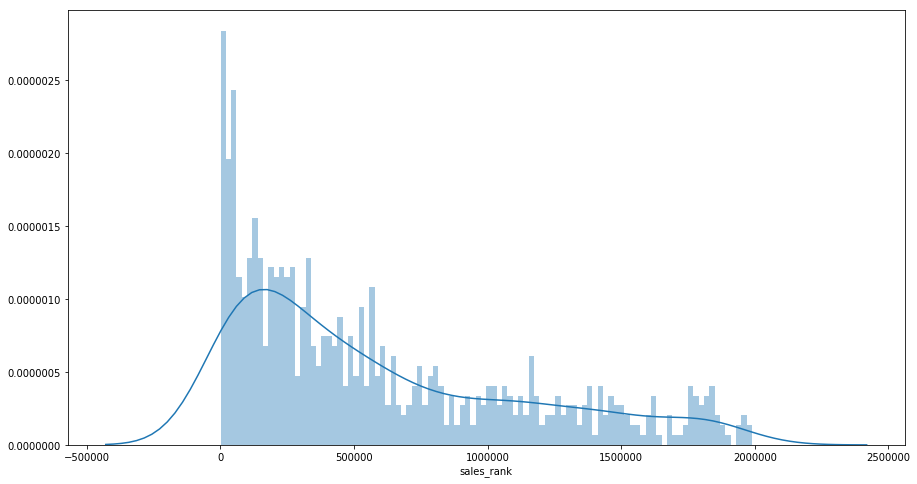

In [73]:
plt.figure(figsize=(15,8))
sns.distplot(srank[srank < 2000000], bins=100)

In [74]:
# classification problem. Find the importance of features to be in the first 25% in sales rank
df_all.describe()

,price,sales_rank
count,953.000000,7.650000e+02
mean,215.676677,6.368142e+05
std,226.423316,6.210059e+05
min,1.019000,3.190000e+02
25%,39.950000,1.501720e+05
50%,119.920000,4.280410e+05
75%,345.950000,1.004701e+06
max,999.000000,5.004443e+06


In [75]:
df_all['color'] = df_all['color'].str.lower()

In [80]:
color_srank = df_all.pivot_table(index='color', values=['sales_rank'], aggfunc=np.mean)

In [81]:
plt.figure(figsize=(15,8))
color_srank.sort_values(by='sales_rank')

,sales_rank
color,
brushed stainless,4.626000e+03
sless/steel,1.080000e+04
red/black,1.590000e+04
piano varnish in silver color - sleek design,1.821100e+04
green/orange,1.931800e+04
"black, clear, stainless",2.688300e+04
matte black,2.718200e+04
piano varnish in dark wine color - sleek design,2.741000e+04
silver (plastic),3.251000e+04


In [97]:
colr_srank_qcut = pd.qcut(df_all['sales_rank'], 4, labels=['0','1','2','3'])

In [99]:
colr_srank_qcut[colr_srank_qcut=='2'].shape[0]

191

In [101]:
colr_srank_qcut

B00004R93U      3
B00004R93V      2
B00004S8FH      1
B00004S8FI      1
B00004S8FJ      1
B00004SC51      1
B00004X139      2
B00005MF9O      3
B00005OTY9      1
B00005V3W4      3
B00006IUTM      3
B00006IUVN      3
B00006IUZK      1
B00008ZCKV      1
B00009ENKU      0
B00009ENKV      1
B00009K3T2      1
B00009KO85      1
B0000DDVN4      1
B0000DDVUO      2
B0000VLI5K      0
B0000ZP3MA      1
B0000ZP3MK      1
B00015NMWC      0
B00016AFOE      3
B0001BMZ2O      2
B0001IT0IY      2
B0001IWX2Y      3
B0001LB9R6      2
B00023XDJA      0
             ... 
B071V8FMMR    NaN
B071VK2TBD      2
B071VZ6QG3    NaN
B071WJG4YB    NaN
B071YBRX3Y    NaN
B071YHPCDP      0
B071ZJF54D    NaN
B071ZVQSP5      0
B0722L18HQ      0
B0722Q8JF4    NaN
B0725RHNKW    NaN
B0725W7MGP    NaN
B0727PP8JX      1
B072C2W4CJ    NaN
B072C6J1XX    NaN
B072F6YFXJ      0
B072J2VHYJ      0
B072JSQ159      0
B072JXNTNS    NaN
B072JYV9Z9    NaN
B072KSZ8KD    NaN
B072NBBHWJ    NaN
B072ND9V5C    NaN
B072P2YQXD    NaN
B072SV42RJ